Notebook where to plot the curves and display the performance of all models in 
a chosen folder. It is also where to conduct the performance analysis about the
models database.

In [443]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpi
import json

from scipy.stats import pearsonr, ttest_1samp
from sklearn.linear_model import LinearRegression

from contrastive.utils.config import get_config_diff
from contrastive.utils.models_database import import_bdd

In [24]:
bdd = pd.read_csv("/neurospin/dico/agaudin/Runs/new_bdd_models_0.csv", index_col=0)
bdd[bdd.exclude != 'bad_learning'].groupby(['num_representation_features','backbone_name', 'foldlabel']).count()

model_path  auc  auc_std  \
num_representation_features backbone_name foldlabel                             
4                           convnet       False               6    6        6   
                                          True                5    5        5   
                            densenet      False              10   10       10   
                                          True               10   10       10   
                            pointnet      False               8    8        8   
                                          True               17   17       17   
10                          convnet       False               5    5        5   
                                          True                5    5        5   
                            densenet      False               5    5        5   
                                          True                5    5        5   
                            pointnet      False               5    5        5   
                                          True                5    5        5   
12                          pointnet      False               1    1        1   
30                          convnet       False               6    6        6   
                                          True                9    9        9   
                            densenet      False              12   12       12   
                                          True               14   14       14   
                            pointnet      False              10   10       10   
                                          True               21   21       21   

                                                     accuracy  accuracy_std  \
num_representation_features backbone_name foldlabel                           
4                           convnet       False             6             6   
                                          True              5             5   
                            densenet      False            10            10   
                                          True             10            10   
                            pointnet      False             8             8   
                                          True             17            17   
10                          convnet       False             5             5   
                                          True              5             5   
                            densenet      False             5             5   
                                          True              5             5   
                            pointnet      False             5             5   
                                          True              5             5   
12                          pointnet      False             1             1   
30                          convnet       False             6             6   
                                          True              9             9   
                            densenet      False            12            12   
                                          True             14            14   
                            pointnet      False            10            10   
                                          True             21            21   

                                                     batch_size  drop_rate  \
num_representation_features backbone_name foldlabel                          
4                           convnet       False               6          6   
                                          True                5          5   
                            densenet      False              10         10   
                                          True               10         10   
                            pointnet      False               8          8   
                                          True               17         17   
10                          convnet       False               5    

## Resume the results

In [217]:
def exclude_conditions(diff_config, excluded_conditions):
    excluded_subdirs = []
    for cond in excluded_conditions:
        filtered_diff_config = diff_config.query(cond)
        excluded_subdirs.extend(filtered_diff_config['Unnamed: 0'].values)
    return excluded_subdirs

dir_path = "/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/densenet"
diff_config = pd.read_csv(dir_path+'/config_diff.csv')
diff_config

#exclude_conditions(diff_config, excluded_conditions=["lr != 0.0004"])

,Unnamed: 0,drop_rate,early_stopping_patience,max_epochs,temperature,temperature_initial,train_val_csv_file,backbone_name
0,tau-0.1_drop-0.0,0.00,250,300,0.1,0.1,/neurospin/dico/data/deep_folding/current/data...,NaN
1,tau-0.1_drop-0.1,0.10,250,300,0.1,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
2,tau-0.5_drop-0.0,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
3,tau-0.5_drop-0.0_2,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
4,tau-0.5_drop-0.0_3,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
5,tau-0.5_drop-0.0_percentage-variable,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
6,tau-0.5_drop-0.1,0.10,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
7,tau-0.5_drop-0.15,0.15,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
8,tau-0.5_drop-0.15_percentage-variable-75,0.15,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
9,tau-0.5_drop-0.15_percentage-variable-75_2,0.15,100,301,0.5,0.5,NaN,densenet


In [244]:
def show_results(dir_path, figsize=(16,10), return_config_diff=False, excluded_conditions=[]):
    # be sure that all models are comparable
    get_config_diff(dir_path, whole_config=False)
    diff_config = pd.read_csv(dir_path+'/config_diff.csv')

    excluded_subdirs = exclude_conditions(diff_config, excluded_conditions)
    if excluded_conditions != []:
        print("Excluded subdirs :", excluded_subdirs)
        print("Excluded because of ", excluded_conditions)

    print(diff_config[~diff_config['Unnamed: 0'].isin(excluded_subdirs)])

    paths = []
    accuracy = []
    accuracy_std = []
    auc = []
    auc_std = []
    # plot all ROC curves
    for subdir in os.listdir(dir_path):
        if os.path.isdir(dir_path + '/' + subdir) and subdir not in excluded_subdirs:
            path = dir_path + '/' + subdir + '/cingulate_ACCpatterns_1_embeddings'
            with open(path+'/values.json', 'r') as file:
                values = json.load(file)
            print(subdir)
            print("AUC", values['cross_val_auc'])
            img = mpi.imread(path+'/cross_val_ROC_curves.png')
            plt.figure(figsize=figsize)
            plt.imshow(img)
            plt.show()

            # store the AUC and accuracy in a df
            paths.append(subdir)
            accuracy.append(values['cross_val_total_accuracy'][0])
            accuracy_std.append(values['cross_val_total_accuracy'][1])
            auc.append(values['cross_val_auc'][0])
            auc_std.append(values['cross_val_auc'][1])

    results_df = pd.DataFrame()
    results_df['path'] = paths
    results_df['auc'] = auc
    results_df['auc_std'] = auc_std
    results_df['accuracy'] = accuracy
    results_df['accuracy_std'] = accuracy_std


    if return_config_diff:
        return results_df, diff_config
    else:
        return results_df

Empty DataFrame
Columns: [Unnamed: 0]
Index: []
10
AUC [0.5495376013419065, 0.07870850324011702]


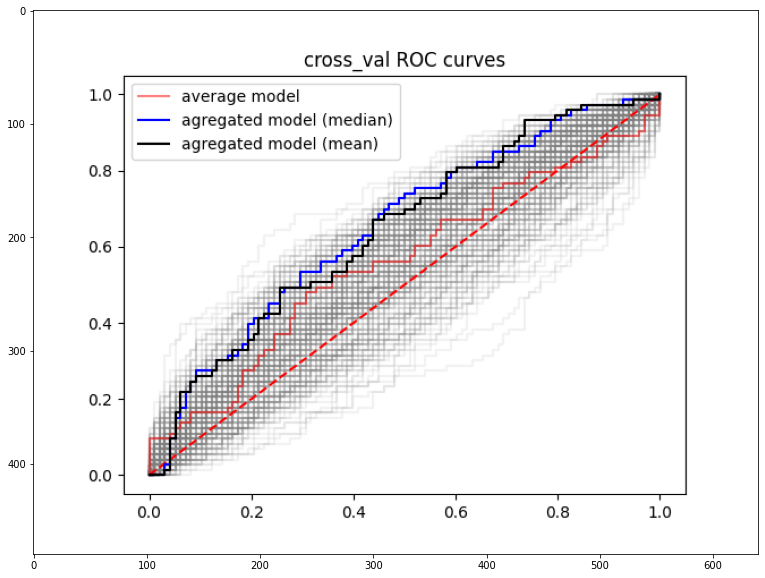

30
AUC [0.5756673189823875, 0.05741971022127]


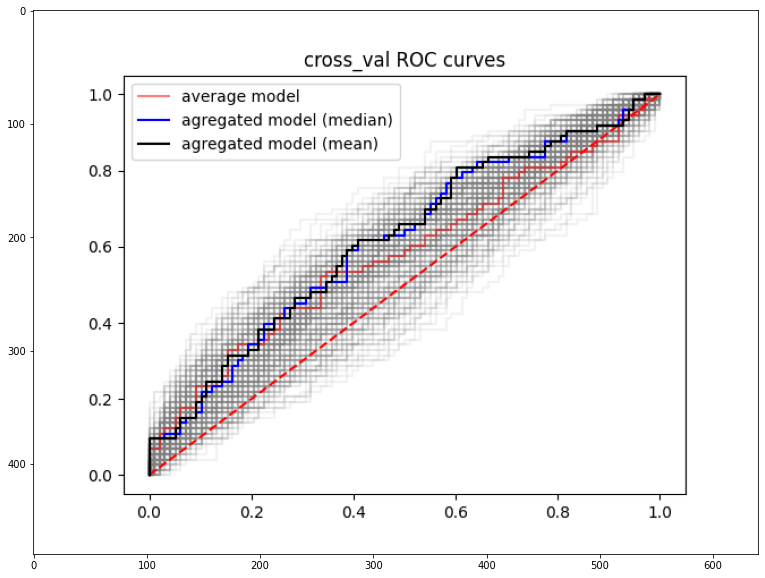

4
AUC [0.5202079955269779, 0.08842502271306545]


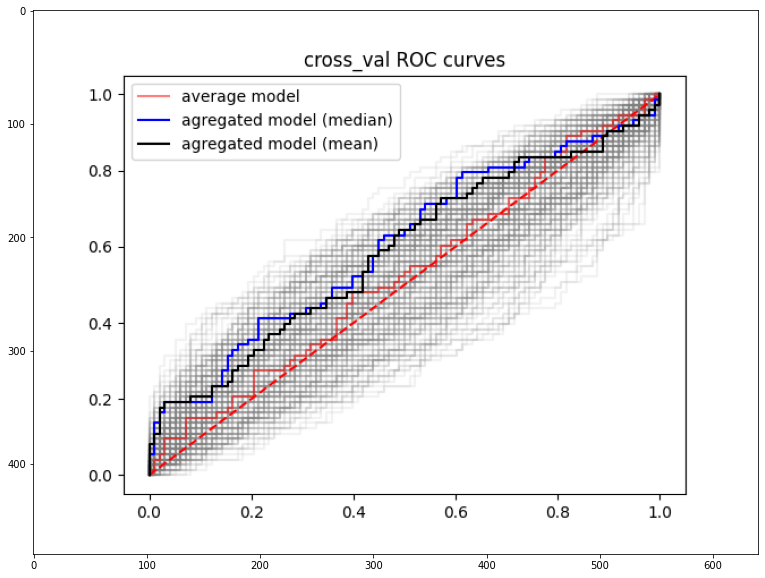

,path,auc,auc_std,accuracy,accuracy_std
0,10,0.549538,0.078709,0.549567,0.053200
1,30,0.575667,0.057420,0.568421,0.043599
2,4,0.520208,0.088425,0.528982,0.057284


In [245]:
excluded_conditions = []

results_df = show_results("/neurospin/dico/agaudin/Runs/04_pointnet/Output/PCA",
excluded_conditions=excluded_conditions)

results_df

In [246]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
1,30,0.575667
0,10,0.549538
2,4,0.520208


In [247]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']].mean()

path    10034.666667
auc         0.548471
dtype: float64

In [14]:
excluded_conditions = []

results_df = show_results("/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/densenet",
excluded_conditions=excluded_conditions)

results_df

                                    Unnamed: 0  drop_rate  \
0                             tau-0.1_drop-0.0       0.00   
1                             tau-0.1_drop-0.1       0.10   
2                             tau-0.5_drop-0.0       0.00   
3                           tau-0.5_drop-0.0_2       0.00   
4                           tau-0.5_drop-0.0_3       0.00   
5         tau-0.5_drop-0.0_percentage-variable       0.00   
6                             tau-0.5_drop-0.1       0.10   
7                            tau-0.5_drop-0.15       0.15   
8     tau-0.5_drop-0.15_percentage-variable-75       0.15   
9   tau-0.5_drop-0.15_percentage-variable-75_2       0.15   
10                          tau-0.5_drop-0.1_2       0.10   
11            tau-0.5_drop-0.2_drop-output-0.0       0.20   
12            tau-0.5_drop-0.2_drop-output-0.1       0.20   

    early_stopping_patience  max_epochs  temperature  temperature_initial  \
0                       250         300          0.1                

FileNotFoundError: [Errno 2] No such file or directory: '/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/densenet/tau-0.5_drop-0.0/cingulate_ACCpatterns_0_embeddings/values.json'

In [12]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
0,without-forcing_foldabel_1,0.541490
1,without-forcing_foldabel_2,0.514956


/volatile/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Program/2022_jchavas_cingulate_inhibitory_control/contrastive/utils/config.py:123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  global_df = pd.concat([global_df, config_df], axis=0)


                                          Unnamed: 0 backbone_name  drop_rate  \
0            tau-0.5_drop-0.0_percentage-variable-75       convnet       0.00   
1          tau-0.5_drop-0.15_cutout_backbone-convnet           NaN       0.15   
2  tau-0.5_drop-0.15_percentage-variable-75_backb...           NaN       0.15   
3  tau-0.5_drop-0.15_percentage-variable-75_backb...       convnet       0.15   
4  tau-0.5_drop-0.25_percentage-variable-75_backb...           NaN       0.25   
5  tau-0.5_drop-0.2_percentage-variable-75_backbo...           NaN       0.15   
6  tau-0.5_drop-0.3_percentage-variable-75_backbo...           NaN       0.30   

   early_stopping_patience  foldlabel  max_angle      patch_size  \
0                      100       True          6             NaN   
1                      250      False         10  [1, 9, 22, 21]   
2                      250       True          6             NaN   
3                      100       True          6             NaN   
4          

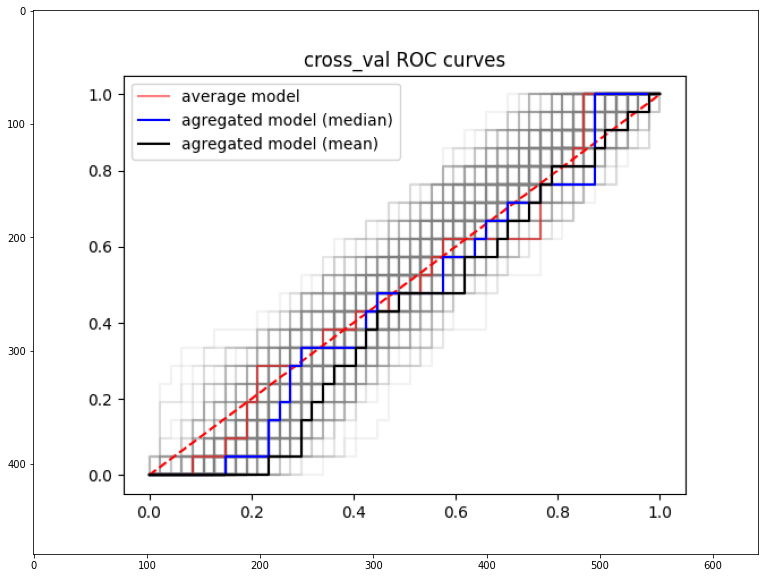

tau-0.5_drop-0.0_percentage-variable-75
AUC [0.5627720364741642, 0.09388947962022412]


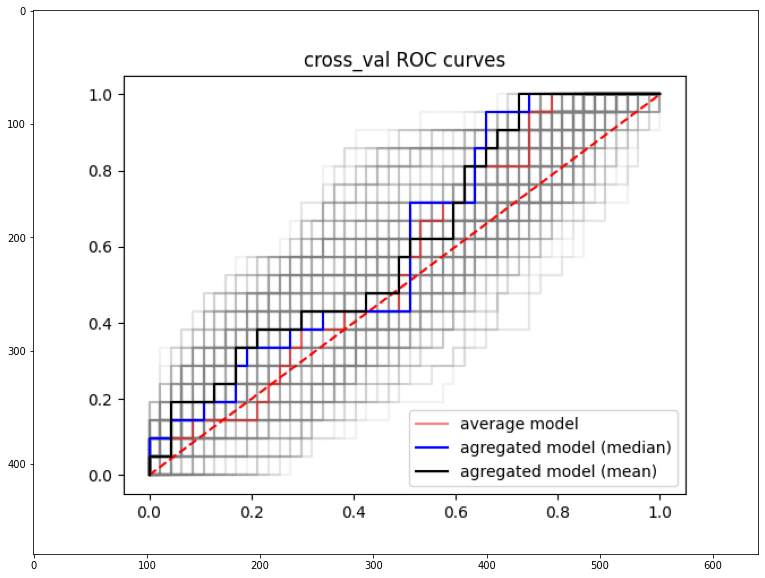

tau-0.5_drop-0.15_cutout_backbone-convnet
AUC [0.5149138804457952, 0.08362887145886067]


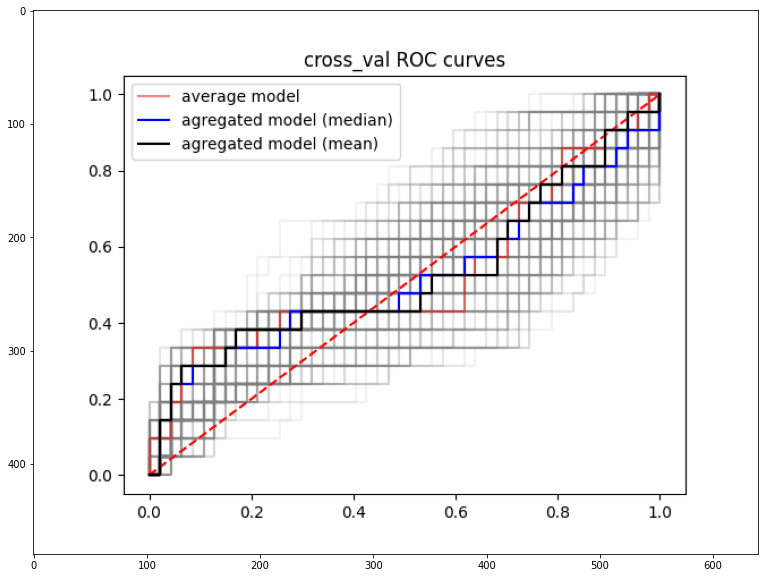

tau-0.5_drop-0.25_percentage-variable-75_backbone-convnet
AUC [0.36738804457953395, 0.10796514149720135]


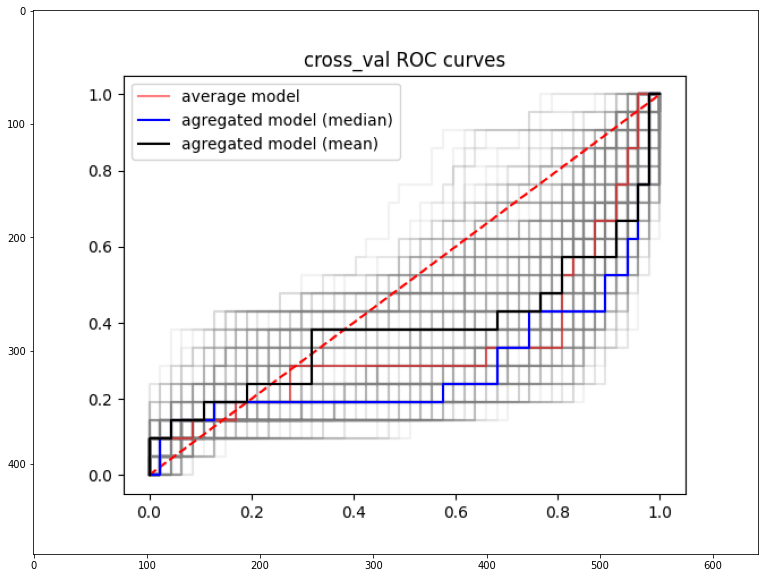

tau-0.5_drop-0.15_percentage-variable-75_backbone-convnet_2
AUC [0.481531914893617, 0.04646467770058261]


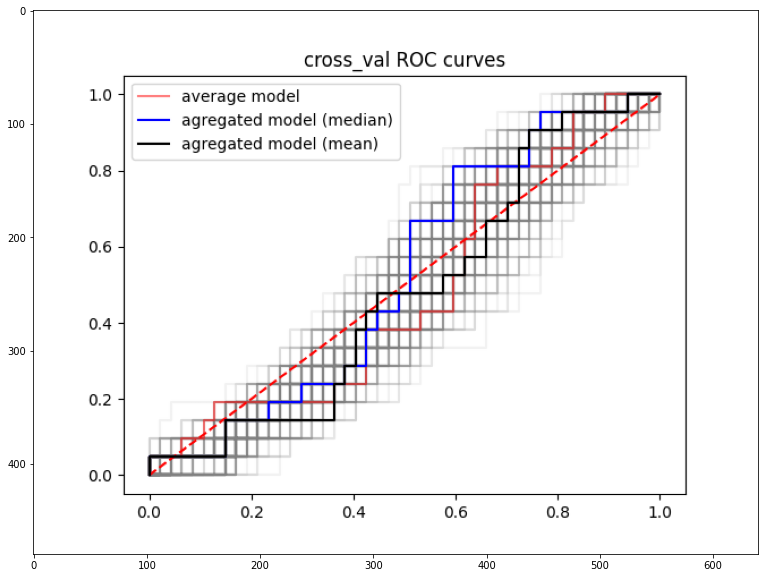

tau-0.5_drop-0.2_percentage-variable-75_backbone-convnet
AUC [0.508838905775076, 0.05888613419413187]


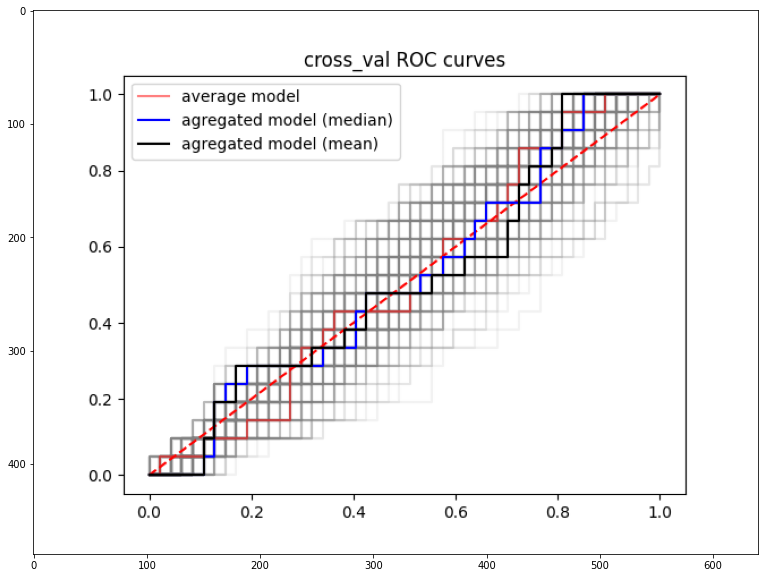

tau-0.5_drop-0.15_percentage-variable-75_backbone-convnet
AUC [0.5013171225937183, 0.061914561197816353]


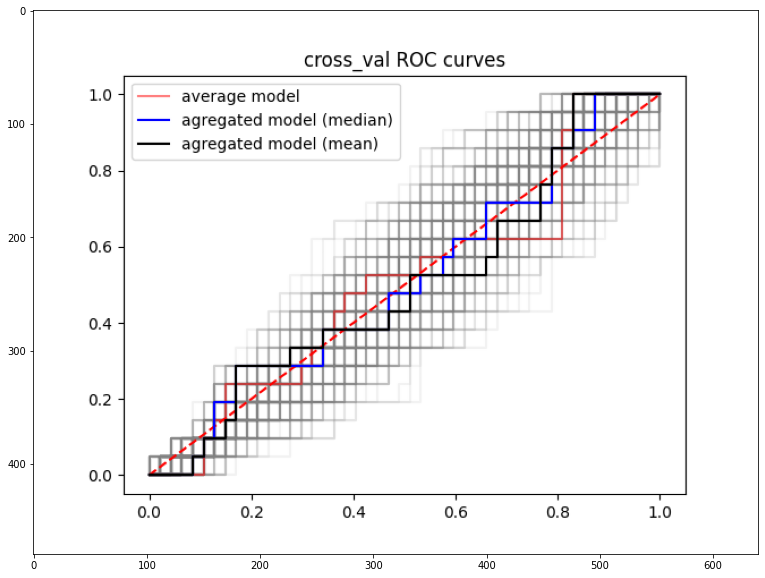

path       auc   auc_std  \
0  tau-0.5_drop-0.3_percentage-variable-75_backbo...  0.494890  0.061100   
1            tau-0.5_drop-0.0_percentage-variable-75  0.562772  0.093889   
2          tau-0.5_drop-0.15_cutout_backbone-convnet  0.514914  0.083629   
3  tau-0.5_drop-0.25_percentage-variable-75_backb...  0.367388  0.107965   
4  tau-0.5_drop-0.15_percentage-variable-75_backb...  0.481532  0.046465   
5  tau-0.5_drop-0.2_percentage-variable-75_backbo...  0.508839  0.058886   
6  tau-0.5_drop-0.15_percentage-variable-75_backb...  0.501317  0.061915   

   accuracy  accuracy_std  
0  0.684294      0.014595  
1  0.640824      0.077700  
2  0.691529      0.030021  
3  0.671471      0.029501  
4  0.613353      0.054943  
5  0.617941      0.040721  
6  0.614294      0.038348

In [19]:
excluded_conditions = []

results_df = show_results("/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/convnet",
excluded_conditions=excluded_conditions)

results_df

In [20]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
9,pointnet_sigmoid_no,0.633446
0,11-05-29,0.611789
2,convnet_sigmoid_fold,0.605882
5,12-18-43,0.556314
7,12-19-16,0.541111
8,densenet_sigmoid_no,0.525296
4,tau-0.5_drop-0.15_percentage-variable-75_backb...,0.481532
3,tau-0.5_drop-0.25_percentage-variable-75_backb...,0.367388


In [ ]:
excluded_conditions = []

results_df = show_results("/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/supervised/acc/aymeric",
excluded_conditions=excluded_conditions)

results_df

In [22]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

path       auc
2                 lr=0.0008  0.564815
1  non_supervised_lr=0.0008  0.555703
0                 lr=0.0004  0.532388

In [ ]:
# convnet exploration
excluded_conditions = []

results_df = show_results("/neurospin/dico/agaudin/Runs/03_monkeys/Output/convnet_exploration",
excluded_conditions=excluded_conditions)

results_df

In [8]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
11,base1,0.673959
2,T_1,0.655674
10,drop_rate_0,0.654164
9,base2,0.648114
14,base3,0.644770
5,batch_size_64,0.636690
8,T_0.01,0.626335
4,T_0.5,0.624267
7,batch_size_4,0.617623
3,drop_rate_0.3,0.609882


In [11]:
# directories are supposed to have a certain structure and name patterns
def get_results_table(dir_path, model_types=['convnet', 'densenet2'], verbose=False):
    results = {k: {} for k in model_types}

    for model_type in os.listdir(dir_path):
        if model_type in model_types:
            if verbose:
                print(model_type)
            path = os.path.join(dir_path, model_type)
            for params in os.listdir(path):
                params_path = os.path.join(path, params)
                if os.path.isdir(params_path):
                    if verbose:
                        print(params)
                    
                    n_models = 0

                    if model_type == 'pca':
                        results[model_type]['foldlabel_'+params] = 0
                        results[model_type]['no_foldlabel_'+params] = 0
                    else:    
                        results[model_type][params] = 0
                    
                    for model in os.listdir(params_path):
                        model_path = os.path.join(params_path, model)
                        # start a model name by & to filter it out of the performance analysis
                        if os.path.isdir(model_path) and model[0] != '&':
                            if verbose:
                                print(model)

                            n_models += 1

                            if model_type == 'pca':
                                values = os.path.join(params_path, model, 'values.json')
                                with open(values, 'r') as file:
                                    values = json.load(file)
                                results[model_type]['foldlabel_'+params] += values['cross_val_auc'][0]
                                results[model_type]['no_foldlabel_'+params] += values['cross_val_auc'][0]
                            else:
                                values = os.path.join(params_path, model, 'cingulate_ACCpatterns_embeddings/values.json')
                                with open(values, 'r') as file:
                                    values = json.load(file)
                                results[model_type][params] += values['cross_val_auc'][0]
                    
                    if model_type == 'pca':
                        results[model_type]['foldlabel_'+params] = results[model_type]['foldlabel_'+params]/n_models
                        results[model_type]['no_foldlabel_'+params] = results[model_type]['no_foldlabel_'+params]/n_models
                    else:
                        results[model_type][params] = results[model_type][params]/n_models
    
    results_df = pd.DataFrame(results)
    results_df.sort_index(inplace=True)
    return results_df

In [12]:
dir_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders"
results_df = get_results_table(dir_path, model_types=['convnet', 'densenet2', 'pca'])

results_df.to_csv("/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/performance_comparison_5000.csv")

results_df

,convnet,densenet2,pca
foldlabel_30,0.613729,0.658608,0.593625
foldlabel_4,0.589703,0.574395,0.538784
no_foldlabel_30,0.649748,0.575910,0.593625
no_foldlabel_4,0.514435,0.488433,0.538784


## Use the database

In [441]:
database_path = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/new_bdd_models_0.csv"
save_fig_path = "/host/home/jc225751/Nextcloud/Travail/05 - Articles/IPMI_2023/figures"

In [251]:
bdd = pd.read_csv(database_path, index_col=0)
bdd.sort_values(by='auc', inplace=True)
bdd = bdd[bdd.exclude == 'False']
bdd

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,dataset_name,drop_rate,early_stopping_patience,...,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,git_branch
95,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.416398,0.016706,0.512024,2.988235e-03,pointnet,16,cingulate_HCP_half_1,0.05,100,...,250,4,4,0.5,0.5,5.256860,5.389712,False,0.129245,pointnet
123,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.426186,0.015647,0.576471,1.110223e-16,pointnet,16,cingulate_HCP_half_1,0.15,100,...,250,4,4,0.1,0.1,4.179968,3.784941,False,-0.562040,pointnet
1,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.476762,0.028876,0.516659,2.880058e-02,densenet,16,cingulate_HCP_half_1,0.15,100,...,250,30,30,0.5,0.5,3.791713,3.817966,False,-0.021195,Run_03_aymeric
164,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.480100,0.073433,0.515106,6.271079e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,6.863671,6.433455,False,NaN,Run_03_aymeric
28,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.487215,0.045323,0.514894,4.708858e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,3.181860,3.173622,False,0.149392,Run_03_aymeric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.761755,0.006579,0.714329,1.351393e-02,convnet,16,cingulate_HCP_half_1,0.05,100,...,251,10,10,0.1,0.1,0.406873,0.600015,False,NaN,Run_03_aymeric
148,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.772037,0.045602,0.667765,5.728143e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,30,30,0.1,0.1,0.679253,1.641905,False,NaN,Run_03_aymeric
150,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.776041,0.043053,0.684612,6.708682e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,30,30,0.1,0.1,0.734627,1.991066,False,NaN,Run_03_aymeric
128,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.776295,0.005263,0.748871,9.152941e-03,convnet,16,cingulate_HCP_half_1,0.05,100,...,251,10,10,0.1,0.1,0.462120,0.800465,False,NaN,Run_03_aymeric


In [252]:
bdd = bdd[~(~(bdd.model_path.str.contains("joel")) & (bdd.backbone_name == "densenet"))]

In [253]:
old_models = bdd[bdd.model_path.str.contains("03_")]
old_models[old_models.drop_rate == 0.05]

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,dataset_name,drop_rate,early_stopping_patience,...,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,git_branch


In [254]:
bdd = import_bdd(database_path, verbose=True)
bdd.sort_values(by='auc', inplace=True)
bdd = bdd[bdd.exclude == 'False']
bdd = bdd[~(~(bdd.model_path.str.contains("joel")) & (bdd.backbone_name == "densenet"))]
bdd

path /neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/new_bdd_models_0.csv
13 have been removed for bad learning


,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,dataset_name,drop_rate,early_stopping_patience,...,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,git_branch
95,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.416398,0.016706,0.512024,2.988235e-03,pointnet,16,cingulate_HCP_half_1,0.05,100,...,250,4,4,0.5,0.5,5.256860,5.389712,False,0.129245,pointnet
123,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.426186,0.015647,0.576471,1.110223e-16,pointnet,16,cingulate_HCP_half_1,0.15,100,...,250,4,4,0.1,0.1,4.179968,3.784941,False,-0.562040,pointnet
164,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.480100,0.073433,0.515106,6.271079e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,6.863671,6.433455,False,NaN,Run_03_aymeric
165,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.502669,0.059634,0.527882,5.158270e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,3.163776,3.043474,False,NaN,Run_03_aymeric
140,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.508278,0.044007,0.522635,4.783800e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,10,10,0.1,0.1,0.806914,1.108339,False,NaN,Run_03_aymeric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.761755,0.006579,0.714329,1.351393e-02,convnet,16,cingulate_HCP_half_1,0.05,100,...,251,10,10,0.1,0.1,0.406873,0.600015,False,NaN,Run_03_aymeric
148,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.772037,0.045602,0.667765,5.728143e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,30,30,0.1,0.1,0.679253,1.641905,False,NaN,Run_03_aymeric
150,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.776041,0.043053,0.684612,6.708682e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,30,30,0.1,0.1,0.734627,1.991066,False,NaN,Run_03_aymeric
128,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.776295,0.005263,0.748871,9.152941e-03,convnet,16,cingulate_HCP_half_1,0.05,100,...,251,10,10,0.1,0.1,0.462120,0.800465,False,NaN,Run_03_aymeric


In [255]:
columns_of_interest = ['backbone_name', 'batch_size', 'drop_rate', 'foldlabel', 'lr', 'num_outputs', 'num_representation_features',
'temperature', 'temperature_initial', 'dataset_name']

In [256]:
interesting_columns = ["model_path", 'auc', 'auc_std', 'backbone_name', 'batch_size', 'dataset_name', 'drop_rate', 'foldlabel',
                       'num_representation_features', 'temperature']
bdd[interesting_columns].iloc[:10,:]

,model_path,auc,auc_std,backbone_name,batch_size,dataset_name,drop_rate,foldlabel,num_representation_features,temperature
95,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.416398,0.016706,pointnet,16,cingulate_HCP_half_1,0.05,True,4,0.5
123,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.426186,0.015647,pointnet,16,cingulate_HCP_half_1,0.15,False,4,0.1
164,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.480100,0.073433,densenet,16,cingulate_HCP_half_1,0.05,False,4,0.1
165,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.502669,0.059634,densenet,16,cingulate_HCP_half_1,0.05,False,4,0.1
140,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.508278,0.044007,densenet,16,cingulate_HCP_half_1,0.05,False,10,0.1
40,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.508307,0.011411,pointnet,16,cingulate_HCP_half_1,0.05,False,4,0.1
136,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.509640,0.037012,densenet,16,cingulate_HCP_half_1,0.05,False,10,0.1
159,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.511759,0.042107,densenet,16,cingulate_HCP_half_1,0.05,True,4,0.1
161,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.512752,0.061656,densenet,16,cingulate_HCP_half_1,0.05,False,4,0.1
138,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.513243,0.048861,densenet,16,cingulate_HCP_half_1,0.05,False,10,0.1


In [257]:
# exclude_bdd = pd.read_csv("/neurospin/dico/agaudin/Runs/new_bdd_models.csv", index_col=0)
# sigmoids = exclude_bdd[exclude_bdd.model_path.str.contains('sigmoid')]
# sigmoids

In [258]:
columns_of_interest = ['backbone_name', 'batch_size', 'drop_rate', 'foldlabel', 'lr', 'num_outputs', 'num_representation_features',
'temperature', 'temperature_initial', 'dataset_name']

In [259]:
interesting_columns = ["model_path", 'auc', 'auc_std', 'backbone_name', 'batch_size', 'dataset_name', 'drop_rate', 'foldlabel',
                       'num_representation_features', 'temperature']
bdd[interesting_columns].iloc[:10,:]

,model_path,auc,auc_std,backbone_name,batch_size,dataset_name,drop_rate,foldlabel,num_representation_features,temperature
95,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.416398,0.016706,pointnet,16,cingulate_HCP_half_1,0.05,True,4,0.5
123,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.426186,0.015647,pointnet,16,cingulate_HCP_half_1,0.15,False,4,0.1
164,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.480100,0.073433,densenet,16,cingulate_HCP_half_1,0.05,False,4,0.1
165,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.502669,0.059634,densenet,16,cingulate_HCP_half_1,0.05,False,4,0.1
140,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.508278,0.044007,densenet,16,cingulate_HCP_half_1,0.05,False,10,0.1
40,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.508307,0.011411,pointnet,16,cingulate_HCP_half_1,0.05,False,4,0.1
136,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.509640,0.037012,densenet,16,cingulate_HCP_half_1,0.05,False,10,0.1
159,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.511759,0.042107,densenet,16,cingulate_HCP_half_1,0.05,True,4,0.1
161,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.512752,0.061656,densenet,16,cingulate_HCP_half_1,0.05,False,4,0.1
138,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.513243,0.048861,densenet,16,cingulate_HCP_half_1,0.05,False,10,0.1


### Performance histogram

In [347]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dimensions = [4, 10, 30]

n_bb = len(backbones)
n_fold = len(foldlabels)
n_dims = len(dimensions)

colors = ['r', 'b', 'g']

pca4 = [0.537, 0.097]
pca10 = [0.548, 0.074]
pca30 = [0.587, 0.055]

bdd_05 = bdd[(bdd.temperature == 0.1) & (bdd.drop_rate == 0.05)]
bdd_05 = bdd_05[bdd_05.num_representation_features != 12]
clean_bdd = bdd_05
bdd_15 = bdd[(bdd.temperature == 0.1) & (bdd.drop_rate == 0.15)]

In [348]:
len(bdd_05)

99

In [261]:
def performance_histogram(bdd, main, x, y, filters, colors=['r', 'b', 'g'], extended=True):
    n_x = len(x)
    n_y = len(y)
    
    plt.figure()
    bins = np.arange(0.45, 0.71, step=0.01)

    for i,element in enumerate(main):
        filtered_bdd = bdd[(bdd[filters[0]] == element) & ~(bdd.model_path.str.contains('unfinished'))]
        print(f"{element}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
        plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)
        plt.xlabel('auc')
    
    if main == dimensions:
        ax = plt.gca()
        y_min, y_max = ax.get_ylim()
        plt.vlines(pca4[0], ymin=y_min, ymax=y_max, colors='blue')
        plt.vlines(pca10[0], ymin=y_min, ymax=y_max, colors='red')
        plt.vlines(pca30[0], ymin=y_min, ymax=y_max, colors='green')

    
    if main == foldlabels:
        plt.legend(["no_foldlabel", "foldlabel"])
    elif main == backbones:
        plt.legend(["convnet", "densenet", "pointnet"])
    elif main == dimensions:
        plt.legend(['pca (dim=4)', 'pca (dim=10)', 'pca (dim=30)'] + main, loc='upper left')
    plt.show()

    if extended:
        plt.figure(figsize=(n_y*6.4, n_x*4.8))

        for j in range(n_x):
            for k in range(n_y):
                pre_filtered_bdd = bdd[(bdd[filters[1]] == x[j]) & (bdd[filters[2]] == y[k])]
                print(x[j], y[k])
                plt.subplot(n_x, n_y, k + n_y*j + 1)
                for i,element in enumerate(main):
                    filtered_bdd = pre_filtered_bdd[(pre_filtered_bdd[filters[0]] == element) & ~(pre_filtered_bdd.model_path.str.contains('unfinished'))]
                    print(f"{element}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
                    plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)
                    plt.xlabel('auc')
                    plt.title(str(x[j])+' '+ str(y[k]))
                print()
                plt.legend(main)
        plt.show()

convnet, N = 31, mean performance: 0.7094893138564197
densenet, N = 30, mean performance: 0.62129243609807
pointnet, N = 39, mean performance: 0.6242899051913136


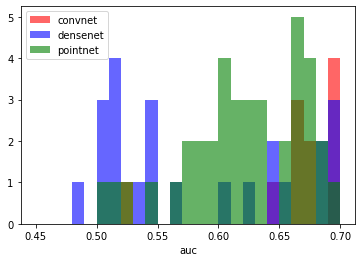

In [262]:
performance_histogram(clean_bdd, backbones, foldlabels, dimensions, filters=['backbone_name', 'foldlabel', 'num_representation_features'],
                      extended=False)

False, N = 49, mean performance: 0.6234161215489182
True, N = 51, mean performance: 0.6751540815501046


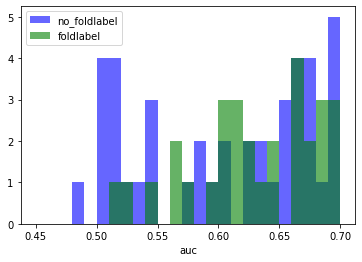

In [263]:
performance_histogram(clean_bdd, foldlabels, dimensions, backbones, filters=['foldlabel', 'num_representation_features', 'backbone_name'],
                      colors=['b', 'g'], extended=False)

4, N = 33, mean performance: 0.6218180955953042
10, N = 30, mean performance: 0.6558840992080429
30, N = 36, mean performance: 0.6702176854618169


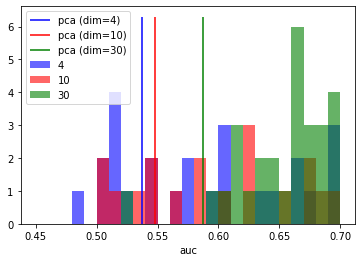

In [264]:
performance_histogram(clean_bdd, dimensions, foldlabels, backbones, filters=['num_representation_features', 'foldlabel', 'backbone_name'],
                      colors=['b', 'r', 'g'], extended=False)

### Results tables

In [320]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dimensions = [4, 10, 30]

n_bb = len(backbones)
n_fold = len(foldlabels)
n_dims = len(dimensions)

colors = ['r', 'b', 'g']

pca4 = [0.537, 0.097]
pca10 = [0.548, 0.074]
pca30 = [0.587, 0.055]

pca = [pca4[0], pca10[0], pca30[0]]
std_pca = [pca4[1], pca10[1], pca30[1]]

bdd_05 = bdd[(bdd.temperature == 0.1) & (bdd.drop_rate == 0.05)]
clean_bdd = bdd_05
bdd_15 = bdd[(bdd.temperature == 0.1) & (bdd.drop_rate == 0.15)]

In [266]:
def significance_over_pca(backbone, foldlabel, dim, bdd=clean_bdd):
    filtered_df = clean_bdd[(clean_bdd.backbone_name == backbone) & (clean_bdd.foldlabel == foldlabel) & (clean_bdd.num_representation_features == dim)]
    aucs = filtered_df.auc

    if dim == 4:
        pca = pca4
    elif dim == 10:
        pca = pca10
    elif dim == 30:
        pca = pca30
    else:
        raise ValueError('Not a dimension the PCA is evaluated for')
    
    return ttest_1samp(aucs, pca[0])

In [321]:
backbones = ['convnet', 'densenet', 'pointnet']
dims = [4, 10, 30]
foldlabels = [False, True]

idx = ['no foldlabel 4', 'foldlabel 4', 'no_foldlabel_10', 'foldlabel_10', 'no foldlabel 30', 'foldlabel 30']

size_rows = len(dims)*len(foldlabels)
df = pd.DataFrame(np.zeros((size_rows,3)), index=idx, columns=backbones)
std_df = pd.DataFrame(np.zeros((size_rows,3)), index=idx, columns=backbones)
count_df = pd.DataFrame(np.zeros((size_rows,3)), index=idx, columns=backbones, dtype=int)
p_values_df = pd.DataFrame(np.zeros((size_rows,3)), index=idx, columns=backbones)

for backbone in backbones:
    i = 0
    for dim in dims:
        for foldlabel in foldlabels:
            filtered_bdd = bdd_05[(bdd_05.backbone_name == backbone) & (bdd_05.foldlabel == foldlabel) & (bdd_05.num_representation_features == dim)]
            df[backbone][i] = filtered_bdd.auc.mean()
            std_df[backbone][i] = filtered_bdd.auc.std()
            count_df[backbone][i] =  filtered_bdd.count()[0]
            p_values_df[backbone][i] = significance_over_pca(backbone, foldlabel, dim, bdd=bdd_05)[1]
            i+=1


df

,convnet,densenet,pointnet
no foldlabel 4,0.693369,0.511710,0.566436
foldlabel 4,0.738893,0.574877,0.653466
no_foldlabel_10,0.720243,0.522744,0.598805
foldlabel_10,0.751668,0.721450,0.620394
no foldlabel 30,0.694047,0.657710,0.647987
foldlabel 30,0.661940,0.739264,0.647554


In [322]:
df_nofoldlabel = df.iloc[[0,2,4],:]
df_foldlabel = df.iloc[[1,3,5],:]
df_foldlabel

,convnet,densenet,pointnet
foldlabel 4,0.738893,0.574877,0.653466
foldlabel_10,0.751668,0.721450,0.620394
foldlabel 30,0.661940,0.739264,0.647554


<AxesSubplot:>

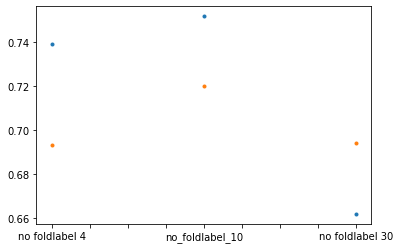

In [323]:
df_foldlabel['convnet'].plot(style='.')
df_nofoldlabel['convnet'].plot(style='.')

In [330]:
def plotting(df, std_df, pca, std_pca, backbone):
    index = ['4','10','30']
    plt.errorbar(index, df.iloc[[0,2,4],:][backbone], std_df.iloc[[0,2,4],:][backbone])
    plt.errorbar(index, df.iloc[[1,3,5],:][backbone], std_df.iloc[[1,3,5],:][backbone])
    plt.plot(index, pca)
    plt.ylim(0.5,1)

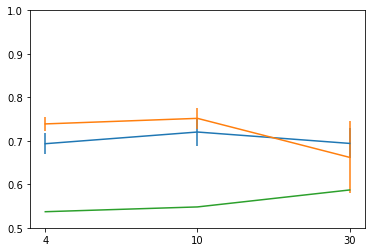

In [334]:
plotting(df, std_df, pca, std_pca, 'convnet')

In [335]:
df1 = sns.load_dataset("penguins")
df1.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


<AxesSubplot:ylabel='convnet'>

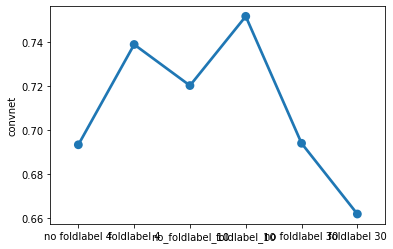

In [333]:
sns.pointplot(data=df, x=df.index, y="convnet")

In [337]:
bdd_05.head()

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,dataset_name,drop_rate,early_stopping_patience,...,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,git_branch
164,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.480100,0.073433,0.515106,6.271079e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,6.863671,6.433455,False,NaN,Run_03_aymeric
165,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.502669,0.059634,0.527882,5.158270e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,3.163776,3.043474,False,NaN,Run_03_aymeric
140,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.508278,0.044007,0.522635,4.783800e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,10,10,0.1,0.1,0.806914,1.108339,False,NaN,Run_03_aymeric
40,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.508307,0.011411,0.552941,1.110223e-16,pointnet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,4.103910,3.400006,False,-0.896763,pointnet
136,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.509640,0.037012,0.518376,5.095511e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,10,10,0.1,0.1,0.701213,0.899798,False,NaN,Run_03_aymeric


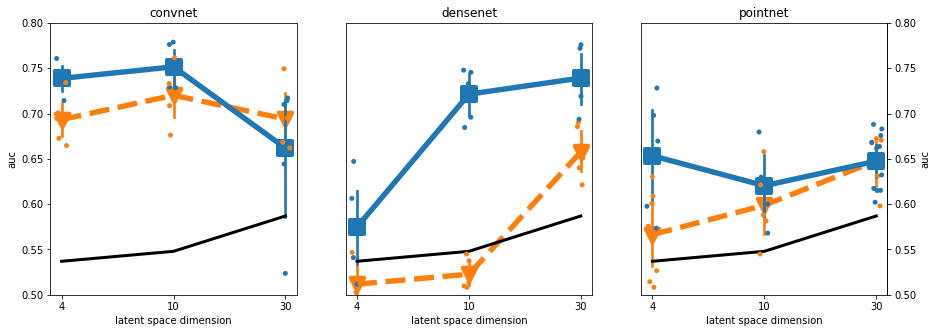

In [442]:
bdd_05['num_representation_features'] = bdd_05['num_representation_features'].astype(str)
f, axs = plt.subplots(1, 3, figsize=(15, 5))
index = ['4','10','30']
backbones = ["convnet", "densenet", "pointnet"]
for ax, backbone in zip(axs, backbones):
    sns.pointplot(data=bdd_05[bdd_05.backbone_name==backbone], x=bdd_05.num_representation_features, y="auc", hue = "foldlabel", palette=['C1', 'C0'], markers=['v', 's'], scale=2, linestyles=['--', '-'], ax=ax)
    sns.stripplot(data=bdd_05[bdd_05.backbone_name==backbone], x=bdd_05.num_representation_features, y="auc", hue = "foldlabel", palette=['C1', 'C0'], jitter=.05, ax=ax)
    ax.plot(index, pca, color='black', linewidth=3)
    ax.set_title(backbone)
    ax.set_xlabel("latent space dimension")
    if backbone != "convnet":
        ax.set_ylabel("")
        ax.set_yticks([])
    if backbone == "pointnet":
        secax = ax.secondary_yaxis('right')
        secax.set_ylabel('auc')
    ax.legend([],[], frameon=False)
    ax.set_ylim([0.5,0.8])
plt.savefig(save_fig_path + "/gridsearch.svg")

<AxesSubplot:xlabel='num_representation_features', ylabel='auc'>

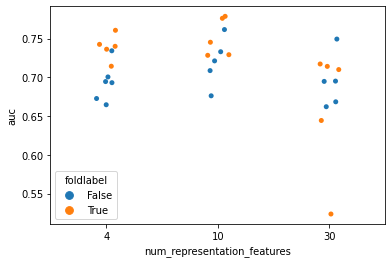

In [365]:
sns.stripplot(data=bdd_05[bdd_05.backbone_name=="convnet"], x=bdd_05.num_representation_features, y="auc", hue = "foldlabel")

In [271]:
std_df

,convnet,densenet,pointnet
no foldlabel 4,0.024422,0.024160,0.049686
foldlabel 4,0.016590,0.053402,0.065810
no_foldlabel_10,0.031458,0.017226,0.042754
foldlabel_10,0.024596,0.029230,0.041121
no foldlabel 30,0.034445,0.029689,0.032650


In [270]:
count_df

,convnet,densenet,pointnet
no foldlabel 4,6,5,7
foldlabel 4,5,5,5
no_foldlabel_10,5,5,5
foldlabel_10,5,5,5
no foldlabel 30,5,5,5
foldlabel 30,5,5,11


In [100]:
print(pca4[0], pca10[0], pca30[0])
p_values_df

0.537 0.548 0.587


,convnet,densenet,pointnet
no foldlabel 4,0.000019,0.079325,0.168051
foldlabel 4,0.000011,0.187929,0.016716
no_foldlabel_10,0.000256,0.030544,0.056560
foldlabel_10,0.000050,0.000186,0.017008
no foldlabel 30,0.002253,0.005983,0.013955
foldlabel 30,0.113637,0.000628,0.000079


#### Significantly over PCA

In [56]:
for backbone in backbones:
    i = 0
    for dim in dims:
        for foldlabel in foldlabels:
            _, p_value = significance_over_pca(backbone, foldlabel, dim)
            

ValueError: Not a dimension the PCA is evaluated for

#### Dispersion table

In [50]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dims = [4, 30]

idx = ['no foldlabel 4', 'foldlabel 4', 'no foldlabel 30', 'foldlabel 30']

disp = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)
disp_std = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)

for backbone in backbones:
    i = 0
    for dim in dims:
        for foldlabel in foldlabels:
            filtered_bdd = clean_bdd[(clean_bdd.backbone_name == backbone) & (clean_bdd.foldlabel == foldlabel) & (clean_bdd.num_representation_features == dim)]
            disp[backbone][i] = filtered_bdd.auc_std.mean()
            disp_std[backbone][i] = filtered_bdd.auc_std.std()
            i+=1

disp

,convnet,densenet,pointnet
no foldlabel 4,0.005374,0.054349,0.010358
foldlabel 4,0.004623,0.075918,0.002809
no foldlabel 30,0.005019,0.034892,0.009016
foldlabel 30,0.024701,0.046243,0.008504


In [51]:
disp_std

,convnet,densenet,pointnet
no foldlabel 4,0.003242,0.009415,0.005157
foldlabel 4,0.005238,0.013172,0.001687
no foldlabel 30,0.000205,0.002413,0.001298
foldlabel 30,0.030481,0.004386,0.002426


### Other parameters repartition

In [16]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dims = [4, 30]

idx = ['no foldlabel 4', 'no foldlabel 30', 'foldlabel 4', 'foldlabel 30']

df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)
count_df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones, dtype=int)


for backbone in backbones:
    i = 0
    for foldlabel in foldlabels:
        for dim in dims:
            filtered_bdd = bdd[(bdd.backbone_name == backbone) & (bdd.foldlabel == foldlabel) & (bdd.num_representation_features == dim)]
            filtered_bdd = filtered_bdd[(filtered_bdd.temperature == 0.1) & (filtered_bdd.drop_rate == 0.15)]
            df[backbone][i] = filtered_bdd.auc.mean()
            count_df[backbone][i] =  filtered_bdd.count()[0]
            i+=1

df

,convnet,densenet,pointnet
no foldlabel 4,0.525272,0.483569,0.486872
no foldlabel 30,0.641102,0.575910,0.590656
foldlabel 4,0.600475,0.583352,0.620886
foldlabel 30,0.609199,0.658608,0.635833


In [17]:
# 0.15
count_df

,convnet,densenet,pointnet
no foldlabel 4,5,4,1
no foldlabel 30,11,5,3
foldlabel 4,5,4,2
foldlabel 30,6,5,4


In [25]:
bdd[bdd.temperature != 0.1].groupby(['backbone_name', 'num_representation_features', 'foldlabel']).count()

model_path  auc  auc_std  \
backbone_name num_representation_features foldlabel                             
convnet       30                          False               3    3        3   
                                          True                3    3        3   
densenet      30                          False               2    2        2   
pointnet      4                           True               10   10       10   
              30                          True                3    3        3   

                                                     accuracy  accuracy_std  \
backbone_name num_representation_features foldlabel                           
convnet       30                          False             3             3   
                                          True              3             3   
densenet      30                          False             2             2   
pointnet      4                           True             10            10   
              30                          True              3             3   

                                                     batch_size  drop_rate  \
backbone_name num_representation_features foldlabel                          
convnet       30                          False               3          3   
                                          True                3          3   
densenet      30                          False               2          2   
pointnet      4                           True               10         10   
              30                          True                3          3   

                                                     early_stopping_patience  \
backbone_name num_representation_features foldlabel                            
convnet       30                          False                            3   
                                          True                             3   
densenet      30                          False                            2   
pointnet      4                           True                            10   
              30                          True                             3   

                                                     input_size  lr  ...  \
backbone_name num_representation_features foldlabel                  ...   
convnet       30                          False               3   3  ...   
                                          True                3   3  ...   
densenet      30                          False               2   2  ...   
pointnet      4                           True               10  10  ...   
              30                          True                3   3  ...   

                                                     max_epochs  num_outputs  \
backbone_name num_representation_features foldlabel                            
convnet       30                          False               3            3   
                                          True                3            3   
densenet      30                          False               2            2   
pointnet      4                           True               10           10   
              30                          True                3            3   

                                                     temperature  \
backbone_name num_representation_features foldlabel                
convnet       30                          False                3   
                                          True                 3   
densenet      30                          False                2   
pointnet      4                           True                10   
              30                          True                 3   

                                                     temperature_initial  \
backbone_name num_representation_features foldlabel                        
convnet       30                          False                        3   
                        

### Correlations

In [22]:
def plot_correlation(x,y, xlabel='', ylabel='', title=''):

    x_regline = x.values.reshape((-1,1))
    y_regline = y.values.reshape((-1,1))
    regline = LinearRegression()
    regline.fit(x_regline, y_regline)

    r, p = pearsonr(x,y)

    plt.figure()
    plt.scatter(x,y)
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = regline.predict([[x_min]])[0]
    y_max = regline.predict([[x_max]])[0]
    plt.plot([x_min, x_max], [y_min, y_max], color='r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title+"r = {:.2f}, p = {:.2E}".format(r, p))

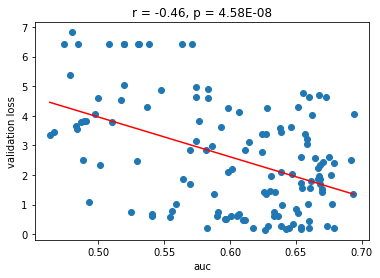

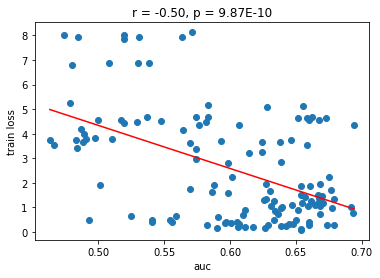

In [23]:
plot_correlation(bdd.auc, bdd.val_loss, xlabel='auc', ylabel='validation loss')
plt.show()
plot_correlation(bdd.auc, bdd.train_loss, xlabel='auc', ylabel='train loss')
plt.show()

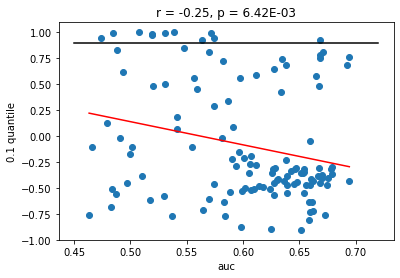

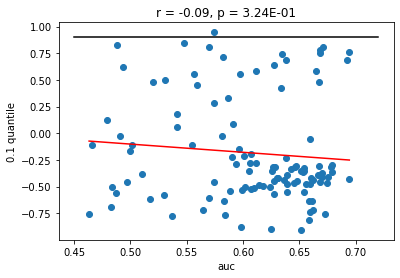

In [27]:
# 0.1 quantile and performance

filtered_bdd = bdd[~bdd['0.1_quantile'].isna()]


plot_correlation(filtered_bdd.auc, filtered_bdd['0.1_quantile'], xlabel='auc', ylabel='0.1 quantile')
plt.plot([0.45,0.72], [0.9, 0.9], color='black')
plt.show()

# same thing without the excluded ones
filtered_bdd = clean_bdd[~clean_bdd['0.1_quantile'].isna()]

plot_correlation(filtered_bdd.auc, filtered_bdd['0.1_quantile'], xlabel='auc', ylabel='0.1 quantile')
plt.plot([0.45,0.72], [0.9, 0.9], color='black')
plt.show()


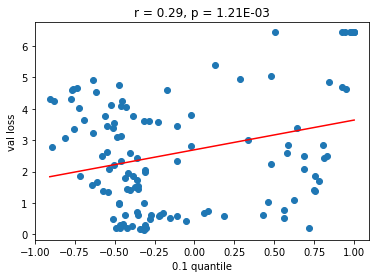

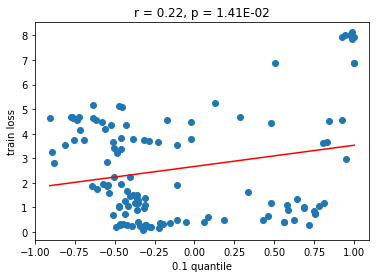

In [36]:
# 0.1 quantile and loss

filtered_bdd = bdd[~bdd['0.1_quantile'].isna()]

plot_correlation(filtered_bdd['0.1_quantile'], filtered_bdd.val_loss,  xlabel='0.1 quantile', ylabel='val loss')
plt.show()
plot_correlation(filtered_bdd['0.1_quantile'], filtered_bdd.train_loss,  xlabel='0.1 quantile', ylabel='train loss')
plt.show()

In [34]:
bdd.iloc[-10:,:]

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,dataset_name,git_branch
45,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.488471,0.035180,0.548809,0.032750,convnet,16,0.15,100,False,...,4,4,0.1,0.1,3.643852,2.511922,False,0.831983,cingulate_HCP_1mm,Run_03_aymeric
128,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.486872,0.025558,0.577713,0.000000,pointnet,16,0.15,100,False,...,4,4,0.1,0.1,4.179968,3.784941,False,-0.562040,cingulate_HCP_half_1,pointnet
20,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.484643,0.042061,0.509701,0.048679,convnet,16,0.15,100,False,...,4,4,0.1,0.1,7.934572,6.433455,bad_learning,0.995956,cingulate_HCP_half_1,Run_03_aymeric
41,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.483937,0.027889,0.506886,0.025827,densenet,16,0.15,100,False,...,4,4,0.1,0.1,3.415136,3.560019,False,-0.506694,cingulate_HCP_half_1,Run_03_aymeric
39,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.482994,0.034076,0.512551,0.030729,densenet,16,0.15,100,False,...,4,4,0.1,0.1,3.753164,3.651408,False,-0.688383,cingulate_HCP_half_1,Run_03_aymeric
59,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.480352,0.022429,0.549314,0.014923,NaN,16,0.15,100,False,...,4,4,0.1,0.1,6.815775,6.824551,structure,NaN,cingulate_HCP_half_1,Run_43_joel
100,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.478818,0.022703,0.576880,0.003572,pointnet,16,0.05,100,True,...,4,4,0.5,0.5,5.256860,5.389712,False,0.129245,cingulate_HCP_half_1,pointnet
19,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.473885,0.042166,0.510393,0.050783,convnet,16,0.15,100,False,...,4,4,0.1,0.1,8.022524,6.433455,bad_learning,0.943119,cingulate_HCP_half_1,Run_03_aymeric
38,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.466274,0.034258,0.547683,0.020623,densenet,16,0.15,100,False,...,4,4,0.1,0.1,3.534628,3.446562,False,-0.106718,cingulate_HCP_half_1,Run_03_aymeric
129,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.463362,0.009882,0.559331,0.002454,pointnet,16,0.05,100,False,...,4,4,0.1,0.1,3.744332,3.345133,False,-0.757010,cingulate_HCP_half_1,pointnet


In [67]:
pointnets = bdd[(bdd.backbone_name == 'pointnet')]
pointnets = pointnets[interesting_columns]
pointnets

,model_path,auc,auc_std,backbone_name,batch_size,dataset_name,drop_rate,foldlabel,num_representation_features,temperature
81,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.50
89,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.678702,0.006920,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
84,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.677713,0.000947,pointnet,16,cingulate_HCP_half_1,0.00,True,30,0.10
78,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.674897,0.015476,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.10
70,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.672935,0.013104,pointnet,16,cingulate_HCP_full,0.05,True,4,0.50
85,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.670079,0.008259,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
88,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.669777,0.006462,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
79,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.668236,0.018538,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.10
86,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.667489,0.007258,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
90,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.666463,0.007006,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10


In [54]:
# consistency analysis
# take models with the same parameters and compare the performance

params = ['backbone_name', 'batch_size', 'drop_rate', 'early_stopping_patience',
        'foldlabel', 'input_size', 'lr', 'max_angle', 'max_epochs',
        'num_outputs', 'num_representation_features', 'numpy_all',
        'temperature', 'temperature_initial', 'git_branch']

df = bdd[params]

bdd[df.duplicated(keep=False) & (bdd.backbone_name == 'pointnet')]


,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,input_size,lr,max_angle,max_epochs,num_outputs,num_representation_features,numpy_all,temperature,temperature_initial,git_branch
71,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,0.669267,0.009264,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.5,0.5,pointnet
68,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.674897,0.015476,0.641771,0.015699,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet
69,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.668236,0.018538,0.655707,0.015699,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet
82,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.614146,0.015697,0.604997,0.017516,pointnet,16,0.15,100,False,"(1, 17, 40, 38)",0.0004,10,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet
72,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.606891,0.013846,0.607930,0.012928,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.5,0.5,pointnet
81,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.588038,0.032487,0.583425,0.027912,pointnet,16,0.15,100,False,"(1, 17, 40, 38)",0.0004,10,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet


In [76]:
bad_models = bdd[bdd.auc <= 0.55]

print("proportion 4 parmi les mauvais modèles :", bad_models[bad_models.num_representation_features == 4].shape[0]/bad_models.shape[0])
print("proportion 4 parmi les modèles :", bdd[bdd.num_representation_features == 4].shape[0]/bdd.shape[0])

bad_models

proportion 4 parmi les mauvais modèles : 0.7931034482758621
proportion 4 parmi les modèles : 0.3853211009174312


,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,max_angle,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,dataset_name,git_branch
27,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.547569,0.057362,0.539683,0.044184,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,4.531240,4.867878,cingulate_HCP_half_1,Run_03_aymeric
34,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.540923,0.033724,0.539085,0.029719,densenet,16,0.15,100,False,...,10,250,30,30,0.1,0.1,0.491312,0.603156,cingulate_HCP_half_1,Run_03_aymeric
30,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.538566,0.027027,0.577713,0.000000,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,6.863671,6.433455,cingulate_HCP_half_1,Run_03_aymeric
76,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.536983,0.005141,0.544880,0.003870,pointnet,16,0.05,100,True,...,6,250,4,4,0.5,0.5,4.673968,4.301939,cingulate_HCP_half_1,pointnet
8,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.530707,0.044796,0.506229,0.049234,convnet,16,0.15,250,True,...,6,250,4,4,0.1,0.1,7.934582,6.433455,cingulate_HCP_half_1,Run_03_aymeric
57,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.530619,0.044917,0.518217,0.051808,convnet,16,0.60,100,False,...,10,250,30,30,0.1,0.1,6.863864,6.437438,cingulate_HCP_half_1,Run_03_aymeric
21,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.529559,0.046242,0.530170,0.036701,convnet,16,0.15,250,False,...,10,250,4,4,0.1,0.1,4.490583,2.484959,cingulate_HCP_half_1,Run_03_aymeric
29,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519898,0.052222,0.517889,0.044333,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,4.442244,5.053896,cingulate_HCP_half_1,Run_03_aymeric
18,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519531,0.036233,0.508657,0.047433,convnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,8.032898,6.433870,cingulate_HCP_half_1,Run_03_aymeric
16,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519293,0.042167,0.507683,0.046822,convnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,7.847290,6.433280,cingulate_HCP_half_1,Run_03_aymeric


### Compare full HCP and half HCP

In [84]:
# first batch

hcp_full = bdd[(bdd.dataset_name == 'cingulate_HCP_full') & (bdd.num_representation_features == 30)]
hcp_half = bdd[(bdd.dataset_name != 'cingulate_HCP_full') & (bdd.num_representation_features == 30) & (bdd.drop_rate == 0.05) & (bdd.foldlabel == True)]

print("Full:", hcp_full.auc.mean(), "Half:", hcp_half.auc.mean())

Full: 0.6439337281443881 Half: 0.6676759259259258


In [85]:
# second batch

hcp_full = bdd[(bdd.dataset_name == 'cingulate_HCP_full') & (bdd.num_representation_features == 4)]
hcp_half = bdd[(bdd.dataset_name != 'cingulate_HCP_full') & (bdd.num_representation_features == 4) & (bdd.drop_rate == 0.05) & (bdd.foldlabel == True)]

print("Full:", hcp_full.auc.mean(), "Half:", hcp_half.auc.mean())

Full: 0.5866613931190072 Half: 0.5914255499153975


Full HCP isn't worth it